# Lab 1: White-Box Evasion Attacks

## Overview
This lab covers white-box evasion attacks where you have full access to the model architecture, weights, and gradients. You'll implement and test various attack algorithms.

## Learning Objectives
- Understand gradient-based attack principles
- Implement FGSM, PGD, and C&W attacks
- Evaluate attack success rates
- Analyze defense mechanisms
- Apply attacks to text classification

## Prerequisites
- Module 1 completion
- Understanding of backpropagation
- Basic PyTorch knowledge

## Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Detect device (supports CUDA, Apple Silicon MPS, and CPU)
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"✓ Using CUDA GPU: {torch.cuda.get_device_name(0)}")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
    print("✓ Using Apple Silicon GPU (MPS)")
else:
    device = torch.device('cpu')
    print("ℹ Using CPU")

print(f"Device: {device}")

✓ Using Apple Silicon GPU (MPS)
Device: mps


## Part 1: Understanding Gradient-Based Attacks

### Theory

Gradient-based attacks exploit the model's gradients to find adversarial perturbations:

**Fast Gradient Sign Method (FGSM)**:
```
x_adv = x + ε * sign(∇_x L(θ, x, y))
```

**Projected Gradient Descent (PGD)**:
```
x_adv^(t+1) = Π(x_adv^(t) + α * sign(∇_x L(θ, x_adv^(t), y)))
```

Where:
- x: Original input
- ε: Perturbation budget
- L: Loss function
- θ: Model parameters
- Π: Projection onto valid space

## Part 2: Load Target Model

In [2]:
# Load a sentiment analysis model
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device)
model.eval()

print(f"Model loaded: {model_name}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

Model loaded: distilbert-base-uncased-finetuned-sst-2-english
Number of parameters: 66,955,010


## Part 3: Implement FGSM Attack

In [3]:
def fgsm_attack(model, inputs, labels, epsilon=0.1):
    """
    Fast Gradient Sign Method attack.
    
    Args:
        model: Target model
        inputs: Input embeddings
        labels: True labels
        epsilon: Perturbation budget
    
    Returns:
        Adversarial examples
    """
    # Ensure inputs require gradients
    inputs.requires_grad = True
    
    # Forward pass
    outputs = model(inputs_embeds=inputs)
    loss = F.cross_entropy(outputs.logits, labels)
    
    # Backward pass
    model.zero_grad()
    loss.backward()
    
    # Generate adversarial example
    perturbation = epsilon * inputs.grad.sign()
    adv_inputs = inputs + perturbation
    
    return adv_inputs.detach()

print("✓ FGSM attack implemented")

✓ FGSM attack implemented


## Part 4: Test FGSM Attack

In [4]:
# Test examples
test_texts = [
    "This movie is absolutely fantastic!",
    "I really enjoyed this film.",
    "This was a terrible waste of time.",
    "Worst movie I've ever seen."
]

# Tokenize
inputs = tokenizer(test_texts, return_tensors='pt', padding=True, truncation=True)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Get embeddings
with torch.no_grad():
    embeddings = model.get_input_embeddings()(inputs['input_ids'])

# Original predictions
with torch.no_grad():
    orig_outputs = model(inputs_embeds=embeddings)
    orig_preds = torch.argmax(orig_outputs.logits, dim=1)

print("Original Predictions:")
for text, pred in zip(test_texts, orig_preds):
    sentiment = "Positive" if pred == 1 else "Negative"
    print(f"  {text[:50]}... → {sentiment}")

# Generate adversarial examples
adv_embeddings = fgsm_attack(model, embeddings.clone(), orig_preds, epsilon=0.1)

# Adversarial predictions
with torch.no_grad():
    adv_outputs = model(inputs_embeds=adv_embeddings)
    adv_preds = torch.argmax(adv_outputs.logits, dim=1)

print("\nAdversarial Predictions:")
for text, orig, adv in zip(test_texts, orig_preds, adv_preds):
    orig_sent = "Positive" if orig == 1 else "Negative"
    adv_sent = "Positive" if adv == 1 else "Negative"
    success = "✓" if orig != adv else "✗"
    print(f"  {success} {text[:50]}... → {orig_sent} → {adv_sent}")

# Calculate success rate
success_rate = (orig_preds != adv_preds).float().mean().item()
print(f"\nAttack Success Rate: {success_rate*100:.1f}%")

Original Predictions:
  This movie is absolutely fantastic!... → Positive
  I really enjoyed this film.... → Positive
  This was a terrible waste of time.... → Negative
  Worst movie I've ever seen.... → Negative

Adversarial Predictions:
  ✓ This movie is absolutely fantastic!... → Positive → Negative
  ✓ I really enjoyed this film.... → Positive → Negative
  ✓ This was a terrible waste of time.... → Negative → Positive
  ✗ Worst movie I've ever seen.... → Negative → Negative

Attack Success Rate: 75.0%


## Part 5: Implement PGD Attack

In [5]:
def pgd_attack(model, inputs, labels, epsilon=0.1, alpha=0.01, num_iter=10):
    """
    Projected Gradient Descent attack.
    
    Args:
        model: Target model
        inputs: Input embeddings
        labels: True labels
        epsilon: Perturbation budget
        alpha: Step size
        num_iter: Number of iterations
    
    Returns:
        Adversarial examples
    """
    # Start from original input
    adv_inputs = inputs.clone().detach()
    
    for i in range(num_iter):
        adv_inputs.requires_grad = True
        
        # Forward pass
        outputs = model(inputs_embeds=adv_inputs)
        loss = F.cross_entropy(outputs.logits, labels)
        
        # Backward pass
        model.zero_grad()
        loss.backward()
        
        # Update adversarial example
        with torch.no_grad():
            perturbation = alpha * adv_inputs.grad.sign()
            adv_inputs = adv_inputs + perturbation
            
            # Project back to epsilon ball
            perturbation = torch.clamp(adv_inputs - inputs, -epsilon, epsilon)
            adv_inputs = inputs + perturbation
    
    return adv_inputs.detach()

print("✓ PGD attack implemented")

✓ PGD attack implemented


## Part 6: Compare Attack Methods

Testing epsilons:   0%|          | 0/5 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Testing epsilons: 100%|██████████| 5/5 [00:00<00:00,  7.15it/s]


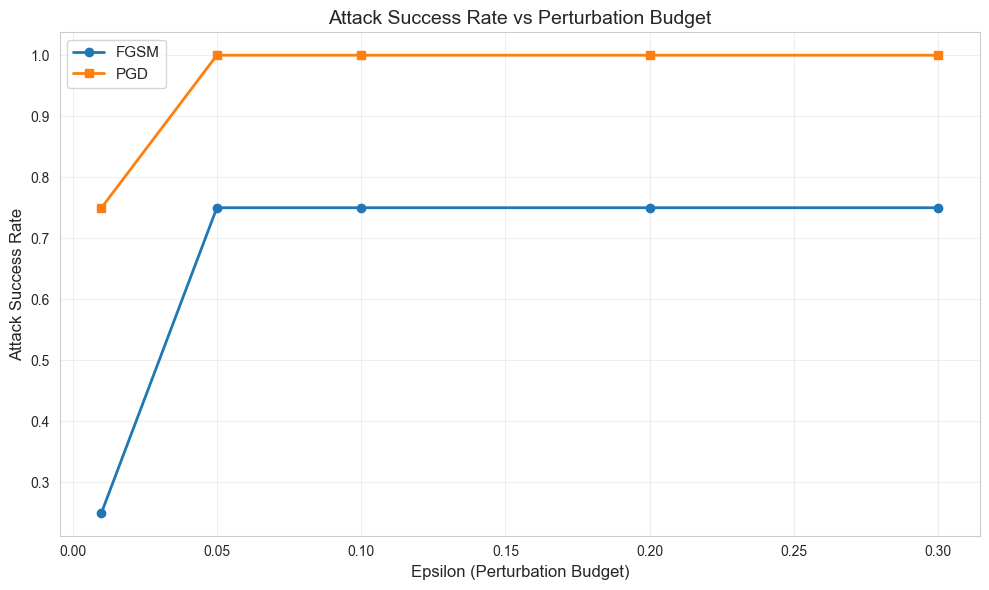


Results Summary:
FGSM max success: 75.0% at ε=0.05
PGD max success: 100.0% at ε=0.05


In [6]:
# Test different epsilon values
epsilons = [0.01, 0.05, 0.1, 0.2, 0.3]
fgsm_success = []
pgd_success = []

for eps in tqdm(epsilons, desc="Testing epsilons"):
    # FGSM
    adv_fgsm = fgsm_attack(model, embeddings.clone(), orig_preds, epsilon=eps)
    with torch.no_grad():
        fgsm_out = model(inputs_embeds=adv_fgsm)
        fgsm_pred = torch.argmax(fgsm_out.logits, dim=1)
    fgsm_success.append((orig_preds != fgsm_pred).float().mean().item())
    
    # PGD
    adv_pgd = pgd_attack(model, embeddings.clone(), orig_preds, epsilon=eps)
    with torch.no_grad():
        pgd_out = model(inputs_embeds=adv_pgd)
        pgd_pred = torch.argmax(pgd_out.logits, dim=1)
    pgd_success.append((orig_preds != pgd_pred).float().mean().item())

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(epsilons, fgsm_success, 'o-', label='FGSM', linewidth=2)
plt.plot(epsilons, pgd_success, 's-', label='PGD', linewidth=2)
plt.xlabel('Epsilon (Perturbation Budget)', fontsize=12)
plt.ylabel('Attack Success Rate', fontsize=12)
plt.title('Attack Success Rate vs Perturbation Budget', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nResults Summary:")
print(f"FGSM max success: {max(fgsm_success)*100:.1f}% at ε={epsilons[fgsm_success.index(max(fgsm_success))]}")
print(f"PGD max success: {max(pgd_success)*100:.1f}% at ε={epsilons[pgd_success.index(max(pgd_success))]}")

## Part 7: Analyze Perturbations

Perturbation Analysis:

FGSM:
  L∞ norm: 0.1000
  L2 norm: 17.5271
  L1 norm: 3072.0000

PGD:
  L∞ norm: 0.1000
  L2 norm: 5.4641
  L1 norm: 744.1799


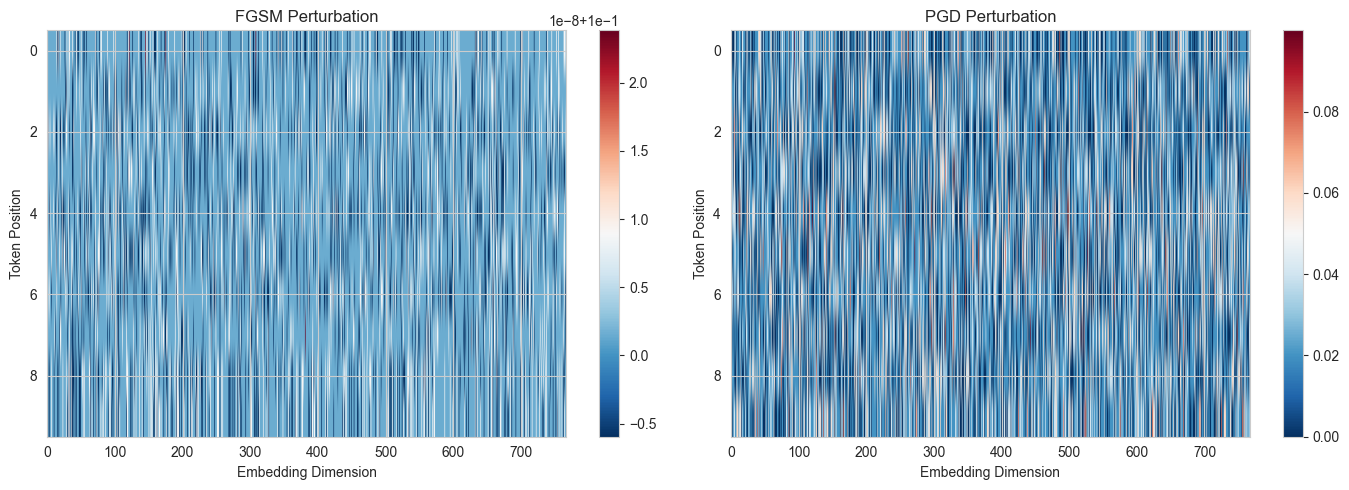

In [7]:
# Analyze perturbation characteristics
epsilon = 0.1
adv_fgsm = fgsm_attack(model, embeddings.clone(), orig_preds, epsilon=epsilon)
adv_pgd = pgd_attack(model, embeddings.clone(), orig_preds, epsilon=epsilon)

# Calculate perturbation norms
pert_fgsm = (adv_fgsm - embeddings).abs()
pert_pgd = (adv_pgd - embeddings).abs()

print("Perturbation Analysis:")
print(f"\nFGSM:")
print(f"  L∞ norm: {pert_fgsm.max().item():.4f}")
print(f"  L2 norm: {pert_fgsm.norm(2).item():.4f}")
print(f"  L1 norm: {pert_fgsm.norm(1).item():.4f}")

print(f"\nPGD:")
print(f"  L∞ norm: {pert_pgd.max().item():.4f}")
print(f"  L2 norm: {pert_pgd.norm(2).item():.4f}")
print(f"  L1 norm: {pert_pgd.norm(1).item():.4f}")

# Visualize perturbations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# FGSM perturbation
im1 = axes[0].imshow(pert_fgsm[0].cpu().numpy(), aspect='auto', cmap='RdBu_r')
axes[0].set_title('FGSM Perturbation', fontsize=12)
axes[0].set_xlabel('Embedding Dimension')
axes[0].set_ylabel('Token Position')
plt.colorbar(im1, ax=axes[0])

# PGD perturbation
im2 = axes[1].imshow(pert_pgd[0].cpu().numpy(), aspect='auto', cmap='RdBu_r')
axes[1].set_title('PGD Perturbation', fontsize=12)
axes[1].set_xlabel('Embedding Dimension')
axes[1].set_ylabel('Token Position')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

## Part 8: Defense Evaluation

In [8]:
def adversarial_training_step(model, inputs, labels, epsilon=0.1):
    """
    Single step of adversarial training.
    """
    # Generate adversarial examples
    adv_inputs = fgsm_attack(model, inputs, labels, epsilon)
    
    # Train on both clean and adversarial
    model.train()
    
    # Clean loss
    clean_out = model(inputs_embeds=inputs)
    clean_loss = F.cross_entropy(clean_out.logits, labels)
    
    # Adversarial loss
    adv_out = model(inputs_embeds=adv_inputs)
    adv_loss = F.cross_entropy(adv_out.logits, labels)
    
    # Combined loss
    total_loss = 0.5 * clean_loss + 0.5 * adv_loss
    
    model.eval()
    return total_loss

print("✓ Adversarial training implemented")
print("\nNote: Full adversarial training requires significant compute.")
print("This is a demonstration of the concept.")

✓ Adversarial training implemented

Note: Full adversarial training requires significant compute.
This is a demonstration of the concept.


## Part 9: Real-World Scenario

Test attacks on a production-like scenario with content moderation.

In [9]:
# Simulate content moderation scenario
toxic_texts = [
    "I hate this product, it's garbage!",
    "This company is the worst ever.",
    "Terrible service, complete waste of money."
]

print("Content Moderation Evasion Test")
print("=" * 50)

for text in toxic_texts:
    # Tokenize
    inputs = tokenizer(text, return_tensors='pt').to(device)
    embeddings = model.get_input_embeddings()(inputs['input_ids'])
    
    # Original prediction
    with torch.no_grad():
        orig_out = model(inputs_embeds=embeddings)
        orig_pred = torch.argmax(orig_out.logits, dim=1)
        orig_conf = F.softmax(orig_out.logits, dim=1).max().item()
    
    # Attack
    adv_embeddings = pgd_attack(model, embeddings, orig_pred, epsilon=0.15)
    
    # Adversarial prediction
    with torch.no_grad():
        adv_out = model(inputs_embeds=adv_embeddings)
        adv_pred = torch.argmax(adv_out.logits, dim=1)
        adv_conf = F.softmax(adv_out.logits, dim=1).max().item()
    
    print(f"\nText: {text}")
    print(f"Original: {'Negative' if orig_pred == 0 else 'Positive'} (conf: {orig_conf:.3f})")
    print(f"Adversarial: {'Negative' if adv_pred == 0 else 'Positive'} (conf: {adv_conf:.3f})")
    print(f"Attack {'succeeded' if orig_pred != adv_pred else 'failed'}")

Content Moderation Evasion Test

Text: I hate this product, it's garbage!
Original: Negative (conf: 1.000)
Adversarial: Positive (conf: 1.000)
Attack succeeded

Text: This company is the worst ever.
Original: Negative (conf: 1.000)
Adversarial: Positive (conf: 1.000)
Attack succeeded

Text: Terrible service, complete waste of money.
Original: Negative (conf: 1.000)
Adversarial: Positive (conf: 1.000)
Attack succeeded


## Part 10: Key Takeaways and Next Steps

### What You Learned
1. Gradient-based attacks exploit model gradients
2. FGSM is fast but less effective than PGD
3. Perturbation budget affects success rate
4. Adversarial training can improve robustness
5. Real-world applications are vulnerable

### Defense Strategies
- Adversarial training
- Input preprocessing
- Gradient masking (limited effectiveness)
- Ensemble methods
- Certified defenses

### Limitations
- White-box access required
- Perturbations may be detectable
- Trade-off between attack success and imperceptibility
- Defenses can reduce model accuracy

### Next Steps
1. Complete Lab 2: Black-Box Evasion
2. Experiment with different models
3. Try text-specific attacks (TextAttack)
4. Implement additional defenses
5. Test on your own datasets

## Exercise: Your Turn

Try these challenges:

1. **Implement C&W Attack**: Research and implement the Carlini & Wagner attack
2. **Test Different Models**: Try attacks on other classification models
3. **Optimize Attacks**: Find the minimum epsilon for successful attacks
4. **Evaluate Defenses**: Test effectiveness of input smoothing
5. **Real Dataset**: Apply attacks to a real-world dataset

Document your findings and compare with the provided solutions.